# Ensemble: Logistic Regresion
### In this workbook, we will use multiple models of Logistic Regression to get predcitions on which various ensemble methods can be used. we would not do 

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import re

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
train_df = pd.read_csv("data/Train.csv")
test_df = pd.read_csv("data/test.csv")

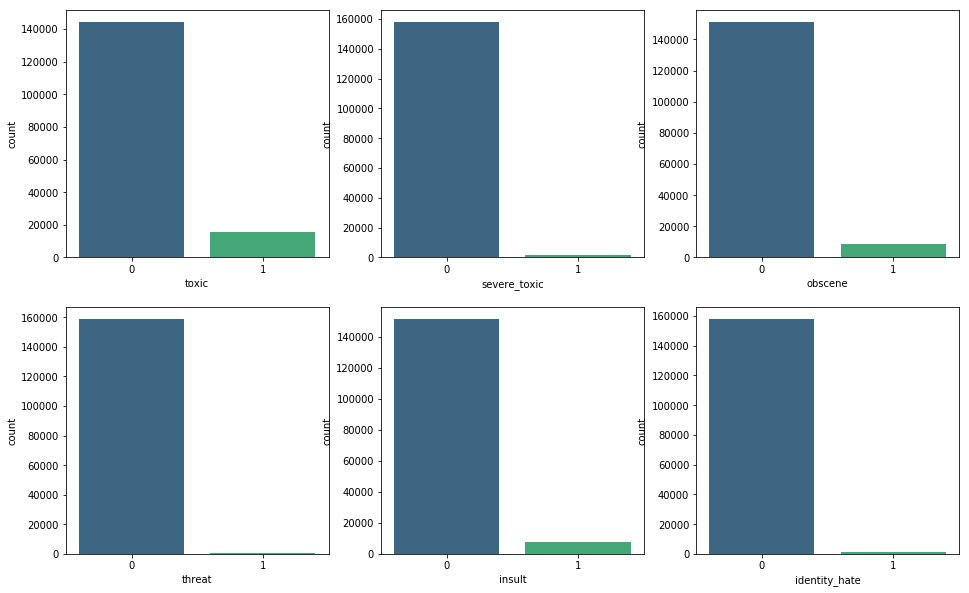

In [4]:
fig,ax = plt.subplots(2,3,figsize=(16,10))
ax1,ax2,ax3,ax4,ax5,ax6 = ax.flatten()
sns.countplot(train_df['toxic'],palette= 'viridis',ax=ax1)
sns.countplot(train_df['severe_toxic'], palette= 'viridis',ax=ax2)
sns.countplot(train_df['obscene'], palette= 'viridis',ax=ax3)
sns.countplot(train_df['threat'], palette= 'viridis',ax = ax4)
sns.countplot(train_df['insult'], palette = 'viridis',ax=ax5)
sns.countplot(train_df['identity_hate'], palette = 'viridis', ax = ax6)

In [5]:
target = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

In [6]:
#[x for x in target train_df[x].sum()/len(train_df)]

base_accuracy = []
print("Base Accuracy for Each Label")
for i in target:
    base_acc = ((train_df[i] == 0).sum()/len(train_df[i]))*100
    print(i+':' ,format(base_acc))
    base_accuracy.append(base_acc)
print(50*'_')
print(base_accuracy)

Base Accuracy for Each Label
toxic: 90.41555169799024
severe_toxic: 99.00044494300343
obscene: 94.7051782592075
threat: 99.70044682304429
insult: 95.06363938309592
identity_hate: 99.11951419744189
__________________________________________________
[90.415551697990239, 99.00044494300343, 94.7051782592075, 99.700446823044288, 95.063639383095918, 99.119514197441887]


### Text pre-processing

In [7]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [8]:
# clean the comment_text in train_df
cleaned_train_comment = []
for i in range(0,len(train_df)):
    cleaned_comment = clean_text(train_df['comment_text'][i])
    cleaned_train_comment.append(cleaned_comment)
train_df['comment_text'] = pd.Series(cleaned_train_comment).astype(str)

In [9]:
## Test set
cleaned_test_comment = []
for i in range(0,len(test_df)):
    cleaned_comment = clean_text(test_df['comment_text'][i])
    cleaned_test_comment.append(cleaned_comment)
test_df['comment_text'] = pd.Series(cleaned_test_comment).astype(str)

In [10]:
X = train_df.comment_text
test_X = test_df.comment_text

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(max_features=40000,stop_words='english')
vect

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=40000, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [12]:
# learn the vocabulary in the training data, then use it to create a document-term matrix
X_dtm = vect.fit_transform(X)
# examine the document-term matrix created from X_train
X_dtm

<159571x40000 sparse matrix of type '<class 'numpy.float64'>'
	with 3813245 stored elements in Compressed Sparse Row format>

In [13]:
test_X_dtm = vect.transform(test_X)
# examine the document-term matrix from X_test
test_X_dtm

<153164x40000 sparse matrix of type '<class 'numpy.float64'>'
	with 3168492 stored elements in Compressed Sparse Row format>

Binary Relevance - build a multi-label classifier using Logistic Regression

In [14]:
#import and instantiate the Logistic Regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
logreg = LogisticRegression(C=12.0)

# create submission file
submission_binary = pd.read_csv("output/sample_submission.csv")

change_acc_bin = []
for i,label in enumerate(target):
    print('... Processing {}'.format(label))
    print(label+" is: ",base_accuracy[i])
    y = train_df[label]
    # train the model using X_dtm & y
    logreg.fit(X_dtm, y)
    # compute the training accuracy
    y_pred_X = logreg.predict(X_dtm)
    print('Training accuracy is         {}'.format(accuracy_score(y, y_pred_X)*100))
    print("Increase from Base accuracy is {}".format(accuracy_score(y, y_pred_X)*100 - base_accuracy[i]))
    change_acc_bin.append(accuracy_score(y, y_pred_X)*100 - base_accuracy[i])
    print("")
    print(50*'_')
    # compute the predicted probabilities for X_test_dtm
    test_y_prob = logreg.predict_proba(test_X_dtm)[:,1]
    submission_binary[label] = test_y_prob


... Processing toxic
toxic is:  90.415551698
Training accuracy is         97.89811431901786
Increase from Base accuracy is 7.4825626210276255

__________________________________________________
... Processing severe_toxic
severe_toxic is:  99.000444943
Training accuracy is         99.41092053067287
Increase from Base accuracy is 0.41047558766943837

__________________________________________________
... Processing obscene
obscene is:  94.7051782592
Training accuracy is         98.99229809927868
Increase from Base accuracy is 4.287119840071185

__________________________________________________
... Processing threat
threat is:  99.700446823
Training accuracy is         99.87027718069072
Increase from Base accuracy is 0.16983035764643262

__________________________________________________
... Processing insult
insult is:  95.0636393831
Training accuracy is         98.46275325717079
Increase from Base accuracy is 3.399113874074871

__________________________________________________
... Pr

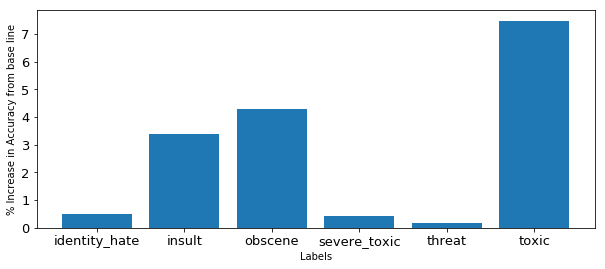

In [15]:
plt.bar(target,change_acc_bin)
plt.ylabel("% Increase in Accuracy from base line")
plt.xlabel("Labels")
plt.gcf().set_size_inches(10,4)
plt.tick_params(labelsize=13)
plt.show()

#### We see an that our model has predictive capability as we see that there is increase in accuracy 

## Classifier Chains

In [16]:
# create submission file
submission_chains = pd.read_csv('output/sample_submission.csv')

# create a function to add features
def add_feature(X, feature_to_add):
    '''
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    '''
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

In [17]:
change_acc_chain = []
for i,label in enumerate(target):
    print('... Processing {}'.format(label))
    print("Base Accuracy for "+label+" is: ",base_accuracy[i])
    
    y = train_df[label]
    
    # train the model using X_dtm & y
    logreg.fit(X_dtm,y)
    
    # compute the training accuracy
    y_pred_X = logreg.predict(X_dtm)
    print('Training Accuracy is {}'.format(accuracy_score(y,y_pred_X)*100))
    print("Increase from Base accuracy is {}".format(accuracy_score(y, y_pred_X)*100 - base_accuracy[i]))
    change_acc_chain.append(accuracy_score(y, y_pred_X)*100 - base_accuracy[i])
    print("")
    # make predictions from test_X
    test_y = logreg.predict(test_X_dtm)
    test_y_prob = logreg.predict_proba(test_X_dtm)[:,1]
    submission_chains[label] = test_y_prob
    
    # chain current label to X_dtm
    X_dtm = add_feature(X_dtm, y)
    print('Shape of X_dtm is now {}'.format(X_dtm.shape))
    
    # chain current label predictions to test_X_dtm
    test_X_dtm = add_feature(test_X_dtm, test_y)
    print('Shape of test_X_dtm is now {}'.format(test_X_dtm.shape))
    print('')
    print(50*'_')

... Processing toxic
Base Accuracy for toxic is:  90.415551698
Training Accuracy is 97.89811431901786
Increase from Base accuracy is 7.4825626210276255

Shape of X_dtm is now (159571, 40001)
Shape of test_X_dtm is now (153164, 40001)

__________________________________________________
... Processing severe_toxic
Base Accuracy for severe_toxic is:  99.000444943
Training Accuracy is 99.5149494582349
Increase from Base accuracy is 0.5145045152314651

Shape of X_dtm is now (159571, 40002)
Shape of test_X_dtm is now (153164, 40002)

__________________________________________________
... Processing obscene
Base Accuracy for obscene is:  94.7051782592
Training Accuracy is 99.15586165405995
Increase from Base accuracy is 4.450683394852447

Shape of X_dtm is now (159571, 40003)
Shape of test_X_dtm is now (153164, 40003)

__________________________________________________
... Processing threat
Base Accuracy for threat is:  99.700446823
Training Accuracy is 99.90098451473011
Increase from Base ac

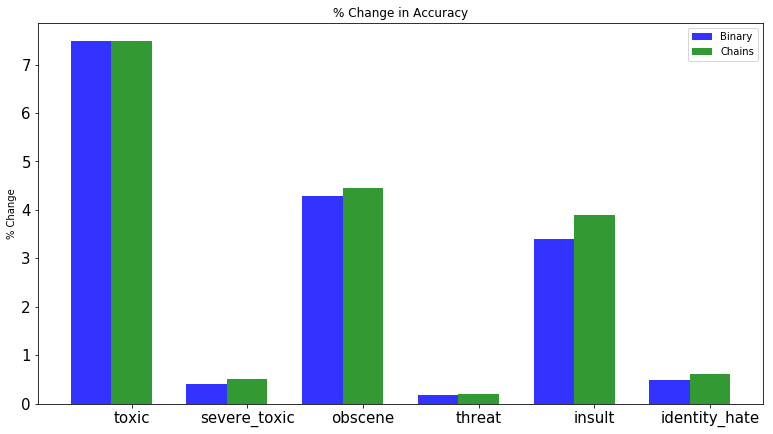

In [18]:
# create plot
fig, ax = plt.subplots()
index = np.arange(len(target))
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index, change_acc_bin, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Binary')
 
rects2 = plt.bar(index + bar_width, change_acc_chain, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Chains')
 
plt.ylabel('% Change')
plt.title('% Change in Accuracy')
plt.xticks(index + bar_width, ('toxic','severe_toxic','obscene','threat','insult','identity_hate'))
plt.legend()
plt.gcf().set_size_inches(13,7)
plt.tick_params(labelsize=15) 
plt.show()

Let's use Feature's generated using Text blob

In [19]:
train_df_pol = pd.read_csv("Data/train_blob.csv")
test_df_pol = pd.read_csv('Data/test_blob.csv')

In [20]:
train_df_pol.head(20)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,polarity
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,2
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,2
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,-1
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0,-1


### Let's Clean the data 

In [21]:
text_link = train_df_pol.comment_text[31045]
print(text_link)
print(100*'_')

text_num = train_df_pol.comment_text[2590]
text_num

references
I don't feel qualified to add these without further confirmation. These are offered in an attempt to respond to Category:Unreferenced_BLPs clean up and provide specific references for Fattouh's bio. I don't feel confident vetting the following online sources and would prefer to have some more closely edited resources as primary sources:

 http://www.webgaza.net/gaza_strip/rafah/people_profiles/Fattouh_Rawhi.htm
 http://www.multaqa.org/access/persons.php?c=r
 Letter to Bethlehem University President, Brother Vincent Malham, in thanks for condolences on the death of President Yasser Arafat http://www.bethlehem.edu/archives/2004/2004_081.shtml
____________________________________________________________________________________________________


"Apology \n\nYou blocked me once  under another IP and it angered me. I was determined to take revenge. Then I discovered your wife is an honest to god African prostitute with AIDS and I realized  nothing I could do would make your life worse than it is. A married virgin, and you'll probably die a virgin. You're like the unicorn of white nights. This is gold man, thanks so much, honestly.  -107.77.76.15"

In [22]:
## Remove URL Links
text_link= re.sub(r'http\S+', '', text_link)
text_link

"references\nI don't feel qualified to add these without further confirmation. These are offered in an attempt to respond to Category:Unreferenced_BLPs clean up and provide specific references for Fattouh's bio. I don't feel confident vetting the following online sources and would prefer to have some more closely edited resources as primary sources:\n\n \n \n Letter to Bethlehem University President, Brother Vincent Malham, in thanks for condolences on the death of President Yasser Arafat "

In [23]:
def clean_text(text):
    text= re.sub(r'http\S+', '', text)
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r"don't", " do not", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub('\n','',text)
    text = re.sub(r"\'ll","will",text)
    text = text.strip(' ')
    return text

In [24]:
text_link = clean_text(text_link)
text_link

'references i do not feel qualified to add these without further confirmation these are offered in an attempt to respond to category unreferenced_blps clean up and provide specific references for fattouh bio i do not feel confident vetting the following online sources and would prefer to have some more closely edited resources as primary sources letter to bethlehem university president brother vincent malham in thanks for condolences on the death of president yasser arafat'

In [25]:
def is_digit(word):
    try:
        int(word)
        return True
    except ValueError:
        return False

new_line = []

text_num= text_num.replace('.','')
for word in text_num.split():
    if not is_digit(word):
        new_line.append(word)
text_num = " ".join(new_line)


text_num = clean_text(text_num)
text_num

'apology you blocked me once under another ip and it angered me i was determined to take revenge then i discovered your wife is an honest to god african prostitute with aids and i realized nothing i could do would make your life worse than it is a married virgin and you will probably die a virgin you are like the unicorn of white nights this is gold man thanks so much honestly'

In [26]:
def clean_text(text):
    text= re.sub(r'http\S+', '', text)
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r"don't", " do not", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub('\n','',text)
    text = re.sub(r"\'ll","will",text)
    text = text.strip(' ')
    
    new_line = []
    text= text.replace('.','')
    
    for word in text.split():
        if not is_digit(word):
            new_line.append(word)
        
    text = " ".join(new_line)
    text = text.translate(str.maketrans('','','1234567890'))
    
    return text

In [27]:
print(clean_text(train_df_pol.comment_text[31045]))
print(234*'_')
print(clean_text(train_df_pol.comment_text[2590]))

references i do not feel qualified to add these without further confirmation these are offered in an attempt to respond to category unreferenced_blps clean up and provide specific references for fattouh bio i do not feel confident vetting the following online sources and would prefer to have some more closely edited resources as primary sources letter to bethlehem university president brother vincent malham in thanks for condolences on the death of president yasser arafat
__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
apology you blocked me once under another ip and it angered me i was determined to take revenge then i discovered your wife is an honest to god african prostitute with aids and i realized nothing i could do would make your life worse than it is a married virgin and you will probably die 

In [28]:
train_df_pol.comment_text = train_df_pol.comment_text.apply(clean_text)

In [29]:
test_df_pol.comment_text = test_df_pol.comment_text.apply(clean_text)

### Let's print 10 random comment and see how our cleaning step performed on test data

In [30]:
for i in range(10):
    print("Comment number {}".format(i))
    print('')
    print(np.random.choice(test_df_pol.comment_text))
    print(234*'_')

Comment number 0

license tagging for image alfred hunt jpg thanks for uploading image alfred hunt jpg wikipedia gets thousands of images uploaded every day and in order to verify that the images can be legally used on wikipedia the source and copyright status must be indicated images need to have an image tag applied to the image description page indicating the copyright status of the image this uniform and easy to understand method of indicating the license status allows potential re users of the images to know what they are allowed to do with the images for more information on using images see the following pages wikipedia image use policy wikipedia image copyright tags this is an automated notice by if you need help on selecting a tag to use or in adding the tag to the image description feel free to post a message at wikipedia media copyright questions
___________________________________________________________________________________________________________________________________

### Revisiting sentiment analysis

In [31]:
from sklearn import *
from textblob import TextBlob

/Users/bobbyvegi/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/bobbyvegi/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/bobbyvegi/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be rem

In [32]:
zpolarity = {0:'zero',1:'one',2:'two',3:'three',4:'four',5:'five',6:'six',7:'seven',8:'eight',9:'nine',10:'ten'}
zsign = {-1:'negative',  0.: 'neutral', 1:'positive'}

In [33]:
train_df_pol['polarity_clean'] = train_df['comment_text'].map(lambda x: int(TextBlob(x).sentiment.polarity * 10))
test_df_pol['polarity_clean'] = test_df['comment_text'].map(lambda x: int(TextBlob(x).sentiment.polarity * 10))

In [34]:
test_df_pol.head(10)

,id,comment_text,polarity,polarity_clean
0,00001cee341fdb12,yo bitch ja rule is more succesful then you wi...,0,0
1,0000247867823ef7,from rfc the title is fine as it is imo,4,4
2,00013b17ad220c46,sources zawe ashton on lapland,0,0
3,00017563c3f7919a,if you have a look back at the source the info...,0,0
4,00017695ad8997eb,i do not anonymously edit articles at all,0,0
5,0001ea8717f6de06,thank you for understanding i think very highl...,2,2
6,00024115d4cbde0f,please do not add nonsense to wikipedia such e...,1,1
7,000247e83dcc1211,dear god this site is horrible,-10,-10
8,00025358d4737918,only a fool can believe in such numbers the co...,1,1
9,00026d1092fe71cc,double redirects when fixing double redirects ...,0,0


### Let's see if they is change in sentiment when using clean data

Percentage change in sentiment polarity before and after cleaning the training data: 7.730%


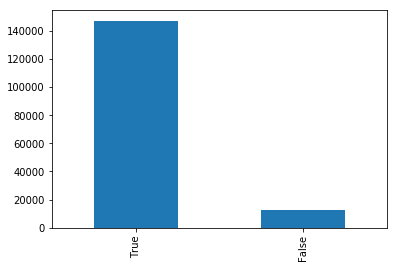

In [35]:
train_aftr_pol = (train_df_pol.polarity == train_df_pol.polarity_clean)
train_aftr_pol.value_counts().plot(kind='bar')
print("Percentage change in sentiment polarity before and after cleaning the training data: {0:.3f}%".format(train_aftr_pol.value_counts(True)[0]*100))

Percentage change in sentiment polarity before and after cleaning the test data: 8.577%


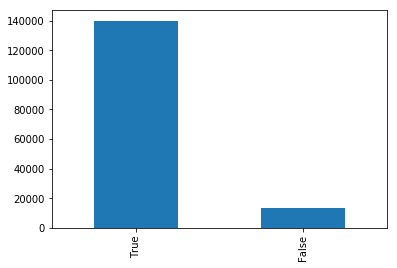

In [36]:
test_aftr_pol = (test_df_pol.polarity == test_df_pol.polarity_clean)
print("Percentage change in sentiment polarity before and after cleaning the test data: {0:.3f}%".format(test_aftr_pol.value_counts(True)[0]*100))
test_aftr_pol.value_counts().plot(kind='bar')
plt.show()

In [37]:
### Adding Sentiment polarity 

In [38]:
train_df_pol['comment_text'] = train_df_pol.apply(lambda r: str(r['comment_text']) + 
                                                  ' polarity' +  zsign[np.sign(r['polarity'])] + 
                                                  zpolarity[np.abs(r['polarity'])], axis=1)
test_df_pol['comment_text'] = test_df_pol.apply(lambda r: str(r['comment_text']) + 
                                                ' polarity' +  zsign[np.sign(r['polarity'])] + 
                                                zpolarity[np.abs(r['polarity'])], axis=1)

In [39]:
train_df_pol.comment_text[2]

'hey man i am really not trying to edit war it just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info polaritypositiveone'

In [40]:
train_df_pol

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,polarity,polarity_clean
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0,1,1
1,000103f0d9cfb60f,d aww he matches this background colour i am s...,0,0,0,0,0,0,2,2
2,000113f07ec002fd,hey man i am really not trying to edit war it ...,0,0,0,0,0,0,1,1
3,0001b41b1c6bb37e,more i cannot make any real suggestions on imp...,0,0,0,0,0,0,2,2
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0,0,0
5,00025465d4725e87,congratulations from me as well use the tools ...,0,0,0,0,0,0,0,0
6,0002bcb3da6cb337,cocksucker before you piss around on my work p...,1,1,1,0,1,0,0,0
7,00031b1e95af7921,your vandalism to the matt shirvington article...,0,0,0,0,0,0,0,0
8,00037261f536c51d,sorry if the word nonsense was offensive to yo...,0,0,0,0,0,0,-1,-1
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0,-1,-1


In [41]:
vect_clean = TfidfVectorizer(max_features=40000,stop_words='english')
vect_clean

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=40000, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [42]:
X = train_df_pol.comment_text
test_X = test_df_pol.comment_text

In [43]:
# learn the vocabulary in the training data, then use it to create a document-term matrix
X_dtm = vect_clean.fit_transform(X)
# examine the document-term matrix created from X_train
X_dtm

<159571x40000 sparse matrix of type '<class 'numpy.float64'>'
	with 3826501 stored elements in Compressed Sparse Row format>

In [44]:
test_X_dtm = vect_clean.transform(test_X)
# examine the document-term matrix from X_test
test_X_dtm

<153164x40000 sparse matrix of type '<class 'numpy.float64'>'
	with 3236274 stored elements in Compressed Sparse Row format>

In [45]:
logreg = LogisticRegression(C=12.0)

# create submission file
submission_binary_pol = pd.read_csv("output/sample_submission.csv")

clean_change_acc_bin = []
for i,label in enumerate(target):
    print('... Processing {}'.format(label))
    print(label+" is: ",base_accuracy[i])
    y = train_df_pol[label]
    # train the model using X_dtm & y
    logreg.fit(X_dtm, y)
    # compute the training accuracy
    y_pred_X = logreg.predict(X_dtm)
    print('Training accuracy is         {}'.format(accuracy_score(y, y_pred_X)*100))
    print("Increase from Base accuracy is {}".format(accuracy_score(y, y_pred_X)*100 - base_accuracy[i]))
    clean_change_acc_bin.append(accuracy_score(y, y_pred_X)*100 - base_accuracy[i])
    print("")
    print(50*'_')
    # compute the predicted probabilities for X_test_dtm
    test_y_prob = logreg.predict_proba(test_X_dtm)[:,1]
    submission_binary_pol[label] = test_y_prob

... Processing toxic
toxic is:  90.415551698
Training accuracy is         97.89310087672573
Increase from Base accuracy is 7.477549178735487

__________________________________________________
... Processing severe_toxic
severe_toxic is:  99.000444943
Training accuracy is         99.42658753783581
Increase from Base accuracy is 0.4261425948323847

__________________________________________________
... Processing obscene
obscene is:  94.7051782592
Training accuracy is         98.99856490214387
Increase from Base accuracy is 4.293386642936369

__________________________________________________
... Processing threat
threat is:  99.700446823
Training accuracy is         99.86463705811207
Increase from Base accuracy is 0.1641902350677782

__________________________________________________
... Processing insult
insult is:  95.0636393831
Training accuracy is         98.46525997831687
Increase from Base accuracy is 3.4016205952209475

__________________________________________________
... Proc

In [46]:
# create submission file
submission_chains_pol = pd.read_csv("output/sample_submission.csv")

clean_change_acc_chain = []
for i,label in enumerate(target):
    print('... Processing {}'.format(label))
    print("Base Accuracy for "+label+" is: ",base_accuracy[i])
    
    y = train_df_pol[label]
    
    # train the model using X_dtm & y
    logreg.fit(X_dtm,y)
    
    # compute the training accuracy
    y_pred_X = logreg.predict(X_dtm)
    print('Training Accuracy is {}'.format(accuracy_score(y,y_pred_X)*100))
    print("Increase from Base accuracy is {}".format(accuracy_score(y, y_pred_X)*100 - base_accuracy[i]))
    clean_change_acc_chain.append(accuracy_score(y, y_pred_X)*100 - base_accuracy[i])
    print("")
    # make predictions from test_X
    test_y = logreg.predict(test_X_dtm)
    test_y_prob = logreg.predict_proba(test_X_dtm)[:,1]
    submission_chains_pol[label] = test_y_prob
    
    # chain current label to X_dtm
    X_dtm = add_feature(X_dtm, y)
    print('Shape of X_dtm is now {}'.format(X_dtm.shape))
    
    # chain current label predictions to test_X_dtm
    test_X_dtm = add_feature(test_X_dtm, test_y)
    print('Shape of test_X_dtm is now {}'.format(test_X_dtm.shape))
    print('')
    print(50*'_')

... Processing toxic
Base Accuracy for toxic is:  90.415551698
Training Accuracy is 97.89310087672573
Increase from Base accuracy is 7.477549178735487

Shape of X_dtm is now (159571, 40001)
Shape of test_X_dtm is now (153164, 40001)

__________________________________________________
... Processing severe_toxic
Base Accuracy for severe_toxic is:  99.000444943
Training Accuracy is 99.51118937651579
Increase from Base accuracy is 0.5107444335123574

Shape of X_dtm is now (159571, 40002)
Shape of test_X_dtm is now (153164, 40002)

__________________________________________________
... Processing obscene
Base Accuracy for obscene is:  94.7051782592
Training Accuracy is 99.14082132718352
Increase from Base accuracy is 4.435643067976017

Shape of X_dtm is now (159571, 40003)
Shape of test_X_dtm is now (153164, 40003)

__________________________________________________
... Processing threat
Base Accuracy for threat is:  99.700446823
Training Accuracy is 99.89471771186493
Increase from Base ac

In [47]:
np.subtract(np.sum(clean_change_acc_chain), np.sum(change_acc_chain))

-0.075828314668697772

In [48]:
np.subtract(np.sum(clean_change_acc_bin), np.sum(change_acc_bin))

0.016293687449490335

In [121]:
submission_binary.to_csv('submission/sub_bin.csv',index=False)
submission_chains.to_csv('submission/sub_chain.csv',index=False)
submission_binary_pol.to_csv('submission/sub_bin_pol.csv',index=False)
submission_chains_pol.to_csv('submission/sub_chain_pol.csv',index=False)

In [ ]:
df = pd.concat([train_df['comment_text'], test_df['comment_text']], axis=0)
df = df.fillna("unknown")
nrow = train_df.shape[0]

In [ ]:
tfidf = feature_extraction.text.TfidfVectorizer(stop_words='english', max_features=800000)
data = tfidf.fit_transform(df)

In [ ]:
model = ensemble.ExtraTreesClassifier(n_jobs=-1, random_state=3)
model.fit(data[:nrow], y)
print(1- model.score(data[:nrow], y))

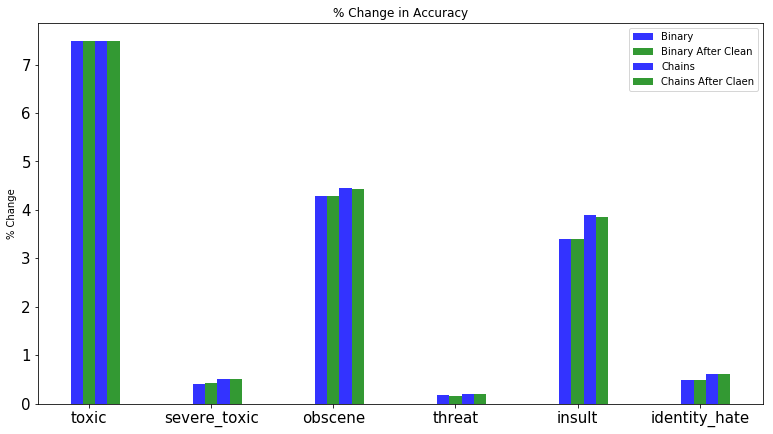

In [49]:
fig, ax = plt.subplots()
index = np.arange(len(target))
bar_width = 0.1
opacity = 0.8
 
rects1 = plt.bar(index, change_acc_bin, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Binary')

rects2 = plt.bar(index + bar_width, clean_change_acc_bin, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Binary After Clean')
 
rects3 = plt.bar(index + 2*bar_width, change_acc_chain, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Chains')


rects4 = plt.bar(index + 3*bar_width, clean_change_acc_chain, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Chains After Claen')

 
plt.ylabel('% Change')
plt.title('% Change in Accuracy')
plt.xticks(index + bar_width, ('toxic','severe_toxic','obscene','threat','insult','identity_hate'))
plt.legend()
plt.gcf().set_size_inches(13,7)
plt.tick_params(labelsize=15) 
plt.show()

In [ ]:
8.77352401125e-05 - 0.00085855199253

In [ ]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='0')
            green_patch = mpatches.Patch(color='blue', label='1')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_dtm, train_df.identity_hate)
plt.show()

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne_model = TSNE()
tsne_features = tsne_model.fit_transform(X_dtm.toarray())

In [ ]:
# Select the 0th feature: xs
xs = tsne_features[:,0]

# Select the 1st feature: ys
ys = tsne_features[:,1]

# Scatter plot, coloring by variety_numbers
plt.scatter(xs,ys, c = train_df.toxic, alpha = 0.3, cmap='viridis')
plt.xticks(np.arange(-75,60,15))
fig = plt.gcf()
fig.set_size_inches(15,10)
plt.title("t-SNE features")
plt.show()

### We see that they is no significant difference in accuracy

## Exploring GridSearch

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss,confusion_matrix,classification_report,roc_curve,auc

import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from scipy import sparse
%matplotlib inline
seed = 123

In [ ]:
vect_word = TfidfVectorizer(max_features=10000, lowercase=True, analyzer='word',
                        stop_words= 'english',ngram_range=(1,2),dtype=np.float32)
vect_char = TfidfVectorizer(max_features=30000, lowercase=True, analyzer='char',
                        stop_words= 'english',ngram_range=(1,6),dtype=np.float32)

In [ ]:
#vect_word.fit(list(train['comment_text']) + list(test['comment_text']))
tr_vect = vect_word.fit_transform(train_df['comment_text'])
ts_vect = vect_word.transform(test_df['comment_text'])

#vect_char.fit(list(train['comment_text']) + list(test['comment_text']))
tr_vect_char = vect_char.fit_transform(train_df['comment_text'])
ts_vect_char = vect_char.transform(test_df['comment_text'])

In [ ]:
X = sparse.hstack([tr_vect, tr_vect_char])
x_test = sparse.hstack([ts_vect, ts_vect_char])

In [ ]:
y = train[target]
#x_test = ts_vet
del tr_vect, ts_vect, tr_vect_char, ts_vect_char
gc.collect()

In [ ]:
prd = np.zeros((x_test.shape[0],y.shape[1]))
cv_score =[]
for i,col in enumerate(target):
    lr = LogisticRegression(C=4,random_state = i)
    print('Building {} model for column:{''}'.format(i,col)) 
    lr.fit(X,y[col])
    #cv_score.append(lr.score)
    prd[:,i] = lr.predict_proba(x_test)[:,1]

In [ ]:
prd_1 = pd.DataFrame(prd,columns=y.columns)
submit = pd.concat([test['id'],prd_1],axis=1)
#submit.to_csv('toxic_lr.csv.gz',compression='gzip',index=False)
submit.to_csv('toxic_lr.csv',index=False)
submit.head()

## Pipeline

In [ ]:
import re
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    return text


from nltk.stem.porter import PorterStemmer

porter = PorterStemmer()

def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    tokenized = [w for w in text.split() if w not in stop]
    return tokenized


def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from nltk.corpus import stopwords

stop = stopwords.words('english')

In [ ]:
tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None,max_features = 5000)

In [ ]:
param_grid = [{'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [clean_text, tokenizer_porter],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]},
              {'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'vect__use_idf':[False],
               'vect__norm':[None],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]},
              ]

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', LogisticRegression(random_state=0))])

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='roc_auc',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)

In [ ]:
for label in target:
    print('')
    print(".............. Started model fitting for "+ label)
    gs_lr_tfidf.fit(train_df.comment_text.values, train_df[label].values)
    print(".............. Completed model fitting for "+ label)
    print('')
    print("Best paramters for "+label)
    gs_lr_tfidf.best_params_
    print('')
    test_y_prob = gs_lr_tfidf.predict_proba(test_df.comment_text)[:,1]
    submission_chains[label] = test_y_prob
    print(".............. Completed model Prediction for "+ label)

In [ ]:
## Output files
submission_binary.to_csv('sub_log_binary.csv',index = False)
#submission_chains.to_csv('sub_log_chain.csv',index=False)

In [ ]:
toxic = pd.read_csv("submission/toxic_lr.csv")
lstm = pd.read_csv("submission/Ensemble.csv")
log_binary = pd.read_csv("submission/sub_log_binary.csv")
log_chains = pd.read_csv("submission/sub_log_chain.csv")
submission_combined = pd.read_csv('output/submission_combined.csv')
target = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

In [ ]:
for label in target:
    submission_combined[label]= pd.concat([toxic[label],lstm[label],log_binary[label],log_chains[label]],
                                          axis =1).max(axis =1)

In [ ]:
submission_combined.head()

In [ ]:
submission_combined.to_csv('submission/submission_combined_max_proba.csv',index=False)

In [ ]:
for label in target:
    submission_combined[label]= pd.concat([toxic[label],lstm[label],log_binary[label],log_chains[label]],
                                          axis =1).sum(axis=1)*0.25

In [ ]:
submission_combined.to_csv('submission/submission_combined_avg_proba.csv',index=False)
submission_combined.head()